# novedad_shell
## El propósito de este notebook es presentar una metodología de extracción de "novedades", basada en la descomposición $k-shell$. Las redes de palabras correspondientes a cada año (entre 2010 y 2016) se descomponen en $k-shells$, las cuales son agrupadas en $K=90$ capas que permiten la comparación a lo largo de los distintos años. Así, describimos la evolución de cada capa en el tiempo. El análisis está basado en la comparación entre la cantidad total de palabras acumuladas (es decir, miramos los nodos involucrados en una capa y vemos en el texto la frecuencia de aparición de estos nodos (palabras)) y la cantidad acumulada de palabras distintas. La hipótesis que subyace a este análisis es que las "novedades" aparecerán en las capas más externas de los grafos, dejando las capas internas (cercanas al $k_{max}-core$) como la parte más estable de los grafos, y por lo tanto de las revistas. 


In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from nltk import sent_tokenize
from nltk import word_tokenize
import numpy as np
import re
import pickle
import string
import operator
import itertools
import community
import json
import statistics
from collections import Counter

In [2]:
#########################################################################################################################
############################################### progress bar ############################################################
#########################################################################################################################
################################# https://github.com/alexanderkuk/log-progress ##########################################
#########################################################################################################################
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )
#########################################################################################################################
#########################################################################################################################
#########################################################################################################################

## Descripción de los grafos por año
### Los grafos están construidos utilizando únicamente sustantivos (comunes y propios) y con co-ocurrencia dentro de una oración. Se utilizaron 2080 introducciones de la revista Cell.

### cell

In [3]:
keys_doi=['2010','2011','2012','2013','2014','2015','2016']

In [20]:
graphs_cell = pickle.load(open( 'graphs_cell.p', 'rb' ) )

In [44]:
for key in keys_doi:
    G=graphs_cell[key]
    print(key)
    print('nodes: '+str(len(G.nodes)))
    print('edges: '+str(len(G.edges)))
    print('average degree: '+str(sum(dict(nx.degree(G,weight='weight')).values())/float(len(G.nodes))))
    print('max degree: '+str(max(dict(nx.degree(G,weight='weight')).values())))
    core_number=nx.core_number(G)
    print('max core number: '+str(max(core_number.values())))
    main_core=nx.k_core(G,max(core_number.values()))
    print('main core size: '+str(len(main_core)))
    main_crust=nx.k_crust(G,max(core_number.values())-1)
    print('main crust size: '+str(len(main_crust)))

2010
nodes: 1000
edges: 59633
average degree: 119.266
max degree: 815
max core number: 97
main core size: 238
main crust size: 762
2011
nodes: 1000
edges: 69832
average degree: 139.664
max degree: 826
max core number: 110
main core size: 239
main crust size: 761
2012
nodes: 1000
edges: 83791
average degree: 167.582
max degree: 869
max core number: 129
main core size: 326
main crust size: 674
2013
nodes: 1000
edges: 81384
average degree: 162.768
max degree: 870
max core number: 120
main core size: 368
main crust size: 632
2014
nodes: 1000
edges: 88079
average degree: 176.158
max degree: 885
max core number: 128
main core size: 361
main crust size: 639
2015
nodes: 1000
edges: 92294
average degree: 184.588
max degree: 894
max core number: 134
main core size: 343
main crust size: 657
2016
nodes: 1000
edges: 98475
average degree: 196.95
max degree: 940
max core number: 126
main core size: 330
main crust size: 670


## core number

In [21]:
core_number={}
for key in keys_doi:
    core_number[key]=nx.core_number(graphs_cell[key])

In [22]:
for key in keys_doi:
    core_number[key]={x:round(core_number[key][x]/float(max(list(core_number[key].values()))),1) for x in core_number[key].keys()}

In [90]:
core_number_evol={x:[] for x in core_number['2010'].keys()}
for x in core_number['2010'].keys():
    for key in keys_doi:
        if x in core_number[key].keys():
            core_number_evol[x]+=[core_number[key][x]]
        else:
            core_number_evol[x]+=[0]

In [91]:
for x in core_number_evol.keys():
    core_number_evol[x]=[core_number_evol[x][0],core_number_evol[x][-1]]#np.mean(core_number_evol[x][0:]),np.std(core_number_evol[x][0:])]

In [92]:
core_number_evol

{'myogenesis': [0.3, 0],
 'stage': [0.9, 1.0],
 'fetal': [0.6, 0.8],
 'skeletal': [1.0, 0.5],
 'myoblast': [0.5, 0],
 'satellite': [0.3, 0.1],
 'muscle': [1.0, 0.8],
 'specific': [1.0, 1.0],
 'fiber': [0.6, 0.7],
 'precursor': [1.0, 1.0],
 'change': [1.0, 1.0],
 'embryonic': [1.0, 0.9],
 'transcriptional': [1.0, 1.0],
 'differentiation': [1.0, 1.0],
 'cell': [1.0, 1.0],
 'pattern': [1.0, 1.0],
 'mouse': [1.0, 1.0],
 'e11': [0.1, 0],
 'basic': [0.8, 0.8],
 'primary': [1.0, 1.0],
 'e145': [0.1, 0],
 'place': [0.7, 0.6],
 'wave': [0.1, 0.4],
 'e175': [0.1, 0],
 'fusion': [1.0, 1.0],
 'secondary': [0.6, 1.0],
 'e16': [0.1, 0],
 'postnatal': [0.5, 0.5],
 'mononucleated': [0.1, 0],
 'basal': [0.9, 0.8],
 'responsible': [1.0, 1.0],
 'lamina': [0.4, 0.3],
 'growth': [1.0, 1.0],
 'individual': [1.0, 1.0],
 'regeneration': [0.7, 0.8],
 'feature': [1.0, 1.0],
 'myotube': [0.1, 0],
 'work': [0.9, 1.0],
 'rise': [0.8, 0.9],
 'previous': [1.0, 1.0],
 'metabolic': [1.0, 1.0],
 'fast': [0.5, 0.5],
 'u

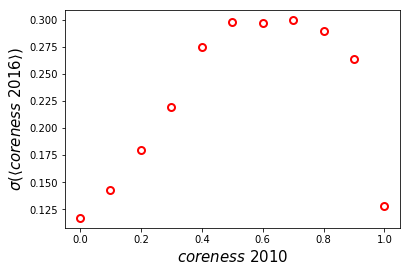

In [93]:
data=list(core_number_evol.values())
X=list(zip(*data))[0]
Y=list(zip(*data))[1]

X_reduced=list(set(X))
Y_dict={x:[] for x in X_reduced}
for x in X_reduced:
    for i in range(len(X)):
        if X[i]==x:
            Y_dict[x]+=[Y[i]]
for x in X_reduced:
    Y_dict[x]=np.std(Y_dict[x])
    
plt.plot(X_reduced,Y_dict.values(),'r',marker='o',markersize=7,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.)

plt.ylabel(r'$\sigma(\langle coreness \ 2016\rangle)$',fontsize=15)
plt.xlabel(r'$coreness \ 2010$',fontsize=15)
plt.rcParams.update({'font.size': 10})
#plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

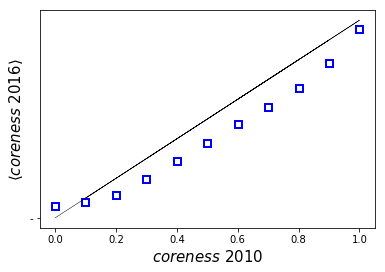

In [105]:
data=list(core_number_evol.values())
X=list(zip(*data))[0]
Y=list(zip(*data))[1]

X_reduced=list(set(X))
Y_dict={x:[] for x in X_reduced}
for x in X_reduced:
    for i in range(len(X)):
        if X[i]==x:
            Y_dict[x]+=[Y[i]]
for x in X_reduced:
    Y_dict[x]=np.mean(Y_dict[x])

X_linear=X_reduced
Y_linear=X_reduced
plt.plot(X_reduced,Y_dict.values(),'b',marker='s',markersize=7,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.)
plt.plot(X_linear,Y_linear,'k','-',linewidth=0.5)
plt.ylabel(r'$\langle coreness \ 2016\rangle$',fontsize=15)
plt.xlabel(r'$coreness \ 2010$',fontsize=15)
plt.rcParams.update({'font.size': 10})
#plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

## k shell decomposition by year

### main core evolution

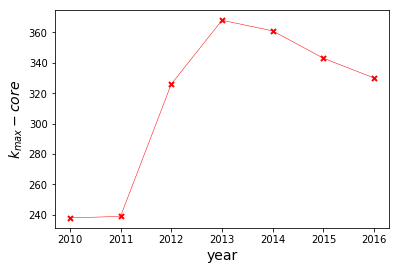

In [45]:
## main core (relative) size
MC=[len(nx.k_core(graphs_cell[year])) for year in keys_doi]
plt.plot(keys_doi,MC,'r',marker='x',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$k_{max}-core$',fontsize=14)
plt.xlabel(r'year',fontsize=14)
plt.rcParams.update({'font.size': 10})
plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

In [82]:
## main core nodes 
k={year:sorted(list(set(list(nx.core_number(graphs_cell[year]).values()))),reverse=True) for year in keys_doi}

In [8]:
k

{'2010': [97,
  96,
  95,
  94,
  93,
  92,
  91,
  90,
  89,
  88,
  87,
  86,
  85,
  84,
  83,
  82,
  81,
  80,
  79,
  78,
  77,
  76,
  75,
  74,
  73,
  72,
  71,
  70,
  69,
  68,
  67,
  66,
  65,
  64,
  63,
  62,
  61,
  60,
  59,
  58,
  57,
  56,
  55,
  54,
  53,
  52,
  51,
  50,
  49,
  48,
  47,
  46,
  45,
  44,
  43,
  42,
  41,
  40,
  39,
  38,
  37,
  36,
  35,
  34,
  33,
  32,
  31,
  30,
  29,
  28,
  27,
  26,
  25,
  24,
  23,
  22,
  21,
  20,
  18,
  17,
  16,
  15,
  14,
  13,
  12,
  11,
  10,
  9,
  8,
  7,
  6,
  5,
  4,
  3,
  2,
  0],
 '2011': [110,
  109,
  108,
  107,
  106,
  105,
  104,
  103,
  102,
  101,
  100,
  99,
  98,
  97,
  96,
  95,
  94,
  93,
  92,
  91,
  90,
  89,
  88,
  87,
  86,
  85,
  84,
  83,
  82,
  81,
  80,
  79,
  78,
  77,
  76,
  75,
  74,
  73,
  72,
  71,
  70,
  69,
  68,
  67,
  66,
  65,
  64,
  63,
  62,
  61,
  60,
  59,
  58,
  57,
  56,
  55,
  54,
  53,
  52,
  51,
  50,
  49,
  48,
  47,
  46,
  45,
  44,
  4

In [569]:
list(range(24,24))

[]

In [120]:
c=0
M=10
main_core={year:decomposition_shell_cell[year][c] for year in keys_doi}

In [121]:
main_core_bool={year:{x:[1 if x in [item for sublist in [decomposition_shell_cell[y][c] for i in range(c-1,M)] for item in sublist] else 0 for y in keys_doi] for x in decomposition_shell_cell[year][c]} for year in keys_doi}

In [122]:
size_main_core_evol={year:[sum(item) for item in list(zip(*list(main_core_bool[year].values())))] for year in keys_doi}

In [123]:
size_main_core_evol

{'2010': [84, 51, 48, 47, 30, 30, 3],
 '2011': [51, 80, 51, 50, 40, 36, 6],
 '2012': [48, 51, 74, 51, 33, 33, 5],
 '2013': [47, 50, 51, 72, 35, 34, 4],
 '2014': [30, 40, 33, 35, 53, 28, 6],
 '2015': [30, 36, 33, 34, 28, 52, 3],
 '2016': [3, 6, 5, 4, 6, 3, 8]}

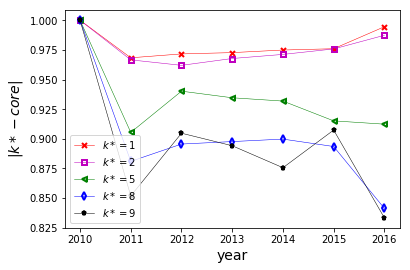

In [7]:
c=9
M=10

for c in [1,2,5,8,9]:
    main_core={year:decomposition_shell_cell[year][c] for year in keys_doi}

    main_core_bool={year:{x:[1 if x in decomposition_shell_cell[y][c] else 0 for y in keys_doi] for x in decomposition_shell_cell[year][c]} for year in keys_doi}

    size_main_core_evol={year:[sum(item) for item in list(zip(*list(main_core_bool[year].values())))] for year in keys_doi}
## comparison
## main core (relative) size
    plot={1:['r','x'],2:['m','s'],5:['green','<'],8:['b','d'],9:['k','*']}
    MC=[len(nx.k_core(graphs_cell[year])) for year in keys_doi]
#for year in ['2010']:
    year='2010'
    plt.plot(keys_doi,[x/float(max(size_main_core_evol[year])) for x in size_main_core_evol[year]],plot[c][0],marker=plot[c][1],markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5,label=r'$k*=$'+str(c))
#plt.plot(keys_doi,[x/float(y)*100 for x,y in zip(MC,[len(graphs_cell[y]) for y in keys_doi])],'b',marker='o',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)
plt.legend(loc='best')

plt.ylabel(r'$|k*-core|$',fontsize=14)
plt.xlabel(r'year',fontsize=14)
plt.rcParams.update({'font.size': 10})
plt.savefig('MC_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

In [5]:
decomposition_shell_cell = pickle.load(open('decomposition_shell_cell.p', 'rb')) 

In [6]:
for key in decomposition_shell_cell.keys():
    seq=list(decomposition_shell_cell[key].keys())
    pieces = 10
    m = float(len(seq))/pieces
    seq_of_seqs=[seq[int(m*i):int(m*(i+1))] for i in range(pieces)]
    S=[]
    for L in seq_of_seqs:
        l=[list(decomposition_shell_cell[key][i].nodes()) for i in L]
        S+=[[item for sublist in l for item in sublist]]
    decomposition_shell_cell[key]=S

In [430]:
seq=list(decomposition_shell_cell[key].keys())
pieces = 10
m = float(len(seq))/pieces
seq_of_seqs=[seq[int(m*i):int(m*(i+1))] for i in range(pieces)]

AttributeError: 'list' object has no attribute 'keys'

In [288]:
len(decomposition_shell_cell['2016'])

10

In [277]:
seq_of_seqs

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
 [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37],
 [38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
 [51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
 [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75],
 [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88],
 [89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100],
 [101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113],
 [114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]]

In [290]:
decomposition_shell_cell['2010']

[['elagib',
  'trx',
  'spp',
  'smad4',
  'holstege',
  'mukherjea',
  'gogh',
  'trpv4',
  'floodgate',
  'amyloidogenic',
  'randomness',
  'prickle',
  'pip2',
  'van',
  'ganglioneuroblastoma',
  'partition',
  'nfrs',
  'oligonucleotide',
  'erbb2her2neu',
  'fj',
  'pentakisphosphate',
  'diphosphoinositol',
  'thoreson',
  'thin',
  'flamingo',
  'ganglioneuroma',
  'k164',
  'megakaryocyte',
  'acetylate',
  'helicobacter',
  'assistance',
  'h3k14',
  'retromer',
  'osteogenesis',
  'ptpn11',
  'fra',
  'phox2b',
  'triobp45deficient',
  'polyribosome',
  'tryptophan',
  'bleau',
  'proteoliposome',
  'ample',
  'colonic',
  'nonenzymatic',
  'atg512',
  'sumo',
  'cytopathic',
  'symptomatology',
  'ionophore',
  'monoubiquitylation',
  'thioesterase',
  'transplant',
  'smad23',
  'initiate',
  'enterocyte',
  'indefinite',
  'dupont',
  'fossil',
  'medical',
  'netrin1',
  'multifactor',
  'gartler',
  'wd40',
  'generic',
  'clarity',
  'enteroendocrine',
  'aedes',
  'g

In [146]:
text_cell = pickle.load(open( 'text_cell.p', 'rb' ) )

In [323]:
main_core_2010=list(nx.k_core(graphs_cell['2010']).nodes())

In [324]:
len(main_core_2010)

238

In [325]:
## filter words belonging to all years (2010-2016)
main_core_2010=[word for word in main_core_2010 if sum([word in [item for sublist in text_cell[year] for item in sublist] for year in keys_doi])==7]

In [326]:
main_core={}
main_core['2010']=main_core_2010
for year in keys_doi[1:]:
    nodes=list(nx.k_core(graphs_cell[year]).nodes())
    main_core[year]=[word for word in main_core_2010 if word in nodes]

In [255]:
main_core_dict={year:{x:Counter([item for sublist in text_cell[year] for item in sublist])[x]/float(max(Counter([item for sublist in text_cell[year] for item in sublist]).values())) for x in main_core[year]} for year in keys_doi}

In [278]:
main_core_dict={}
for year in keys_doi:
    print(year)
    PR=nx.clustering(graphs_cell[year],weight='weight')
    main_core_dict[year]={x:PR[x] for x in main_core[year]} 

2010
2011
2012
2013
2014
2015
2016


In [333]:
cores={year:nx.k_core(graphs_cell[year]) for year in keys_doi}

main_core_bool={x:[1] for x in main_core_2010}
for x in main_core_bool.keys():
    print(x)
    for year in keys_doi[1:]:
        nodes=list(cores[year].nodes())
        if x in nodes:
            main_core_bool[x]+=[1]
        else:
            main_core_bool[x]+=[0]

differentiation


KeyError: 'differentiation'

In [328]:
main_core_bool

{'differentiation': [1, 1, 1, 1, 1, 1, 1],
 'phase': [1, 1, 1, 1, 1, 1, 1],
 'model': [1, 1, 1, 1, 1, 1, 1],
 'result': [1, 1, 1, 1, 1, 1, 1],
 'chromatin': [1, 1, 1, 1, 1, 1, 1],
 'population': [1, 1, 1, 1, 1, 1, 1],
 'terminal': [1, 1, 1, 1, 1, 1, 1],
 'regulatory': [1, 1, 1, 1, 1, 1, 1],
 'cycle': [1, 1, 1, 1, 1, 1, 1],
 'molecule': [1, 1, 1, 1, 1, 1, 1],
 'eukaryote': [1, 0, 0, 1, 1, 0, 0],
 'step': [1, 1, 1, 1, 1, 1, 1],
 'low': [1, 1, 1, 1, 1, 1, 1],
 'induction': [1, 0, 1, 1, 1, 1, 0],
 'muscle': [1, 0, 1, 1, 1, 1, 0],
 'dna': [1, 1, 1, 1, 1, 1, 1],
 'cell': [1, 1, 1, 1, 1, 1, 1],
 'member': [1, 1, 1, 1, 1, 1, 1],
 'state': [1, 1, 1, 1, 1, 1, 1],
 'independent': [1, 1, 0, 1, 1, 1, 1],
 'common': [1, 1, 1, 1, 1, 1, 1],
 'normal': [1, 1, 1, 1, 1, 1, 1],
 'synthesis': [1, 0, 1, 1, 1, 1, 1],
 'substrate': [1, 1, 1, 1, 1, 1, 1],
 'crucial': [1, 0, 1, 1, 0, 1, 0],
 'domain': [1, 1, 1, 1, 1, 1, 1],
 'unclear': [1, 1, 1, 1, 1, 1, 1],
 'spindle': [1, 0, 0, 0, 0, 0, 0],
 'manner': [1, 1, 

In [329]:
average_main_core_bool=np.mean(list(main_core_bool.values()), axis=0)

In [330]:
average_main_core_bool

array([1.        , 0.78571429, 0.91176471, 0.94537815, 0.89915966,
       0.92016807, 0.87394958])

In [248]:
from collections import Counter

In [249]:
main_core_dict={x:[Counter([item for sublist in text_cell[year] for item in sublist])[x]/float(max(Counter([item for sublist in text_cell[year] for item in sublist]).values())) for year in keys_doi] for x in main_core_2010}

In [250]:
main_core_dict['cell']

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [279]:
main_core_dict

{'2010': {'differentiation': 0.003318670058180217,
  'phase': 0.0033785156484215637,
  'model': 0.0024470137598122704,
  'result': 0.0026958143931738007,
  'chromatin': 0.004339523087092046,
  'population': 0.0034403060933880687,
  'terminal': 0.0034291941927009095,
  'regulatory': 0.004109975773433474,
  'cycle': 0.0035311797202233165,
  'molecule': 0.0030219409760582033,
  'eukaryote': 0.004546737122132425,
  'step': 0.003653049084661587,
  'low': 0.003242117704430591,
  'induction': 0.004283172926146308,
  'muscle': 0.0037285734504861464,
  'dna': 0.002972879530985394,
  'cell': 0.0019500048699114955,
  'member': 0.0035785799784358147,
  'state': 0.002809806581677643,
  'independent': 0.0033710416082855608,
  'common': 0.0027991299260406812,
  'normal': 0.003975667456211153,
  'synthesis': 0.003475033140097627,
  'substrate': 0.0034873648697829897,
  'crucial': 0.0032822966672221444,
  'domain': 0.002601304240238557,
  'unclear': 0.004160875041838758,
  'spindle': 0.0047898758695590

In [280]:
frequency_2010=list(main_core_dict['2010'].values())
frequency_2013=list(main_core_dict['2013'].values())
frequency_2016=list(main_core_dict['2016'].values())

In [281]:
frequency_2010

[0.003318670058180217,
 0.0033785156484215637,
 0.0024470137598122704,
 0.0026958143931738007,
 0.004339523087092046,
 0.0034403060933880687,
 0.0034291941927009095,
 0.004109975773433474,
 0.0035311797202233165,
 0.0030219409760582033,
 0.004546737122132425,
 0.003653049084661587,
 0.003242117704430591,
 0.004283172926146308,
 0.0037285734504861464,
 0.002972879530985394,
 0.0019500048699114955,
 0.0035785799784358147,
 0.002809806581677643,
 0.0033710416082855608,
 0.0027991299260406812,
 0.003975667456211153,
 0.003475033140097627,
 0.0034873648697829897,
 0.0032822966672221444,
 0.002601304240238557,
 0.004160875041838758,
 0.004789875869559046,
 0.0037248090154328,
 0.0029051082464867915,
 0.002906407042039508,
 0.0031398293713918867,
 0.004403515251558698,
 0.0032770720485988743,
 0.0027551114013250125,
 0.0038886627612274094,
 0.003818461376713779,
 0.0037479800768588007,
 0.004915949929394184,
 0.0034549261726493784,
 0.0031539505357577133,
 0.0041380381556348515,
 0.0031560066

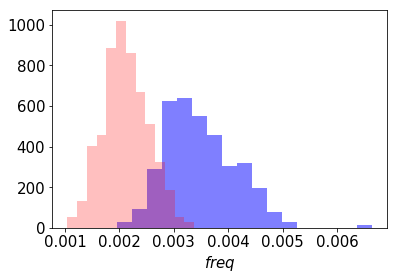

In [283]:
data = np.array(frequency_2010) 
data2 = np.array(frequency_2013) 
data3 = np.array(frequency_2016) 

#plt.legend(loc='best')
#plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', color='blue',alpha=0.5,density=True)
#plt.hist(data2, bins='auto', color='red',alpha=0.25,density=True)
plt.hist(data3, bins='auto', color='red',alpha=0.25,density=True)

plt.xlabel('$freq$')
#plt.ylabel('$freq$')
plt.show()

### core number evolution

In [9]:
nodes=graphs_cell['2016'].nodes()
for key in log_progress(keys_doi[:-1],every=1):
    graphs_cell[key]=graphs_cell[key].subgraph(nodes)

In [10]:
## en el diccionario "core_number_by_year" guardamos el "core_number" de cada nodo del grafo x año
core_number_by_year={}
for key in log_progress(keys_doi,every=1):
    G=graphs_cell[key]
    core_number_by_year[key]=nx.core_number(G)

In [11]:
## normalizamos por el valor máximo de cada año
for key in log_progress(keys_doi,every=1):
    G=graphs_cell[key]
    core_number_by_year[key]={x:core_number_by_year[key][x]/float(max(core_number_by_year[key].values())) for x in core_number_by_year[key].keys()}

In [12]:
## extraemos las palabras del 2016
words_2016=list(core_number_by_year['2016'].keys())
## y creamos un diccionario donde se guarda el core number normalizado de estas palabras en 2010-2016
words_evolution={word:[] for word in words_2016}

In [13]:
for word in log_progress(words_2016,every=100):
    for key in keys_doi[:-1]:
        if word in core_number_by_year[key].keys() and word in words_evolution.keys():
            words_evolution[word]+=[core_number_by_year[key][word]]
        else:
            if word in words_evolution.keys():
                del words_evolution[word]
    

In [14]:
words_evolution={word:np.mean(words_evolution[word]) for word in words_evolution.keys()}

In [15]:
words_evolution

{'cell': 1.0,
 'protein': 1.0,
 'gene': 1.0,
 'function': 1.0,
 'response': 1.0,
 'mechanism': 1.0,
 'human': 1.0,
 'complex': 1.0,
 'study': 1.0,
 'activity': 1.0,
 'receptor': 1.0,
 'specific': 1.0,
 'expression': 1.0,
 'rna': 1.0,
 'dna': 1.0,
 'mouse': 1.0,
 'factor': 1.0,
 'role': 1.0,
 'system': 1.0,
 'pathway': 1.0,
 'type': 1.0,
 'domain': 1.0,
 'activation': 1.0,
 'disease': 1.0,
 'signaling': 1.0,
 'neuron': 1.0,
 'membrane': 1.0,
 'structure': 1.0,
 'model': 1.0,
 'immune': 0.9984848484848485,
 'site': 1.0,
 'level': 1.0,
 'transcription': 1.0,
 'process': 1.0,
 'interaction': 1.0,
 'cancer': 1.0,
 'infection': 0.9900634249471459,
 'development': 1.0,
 'mutation': 1.0,
 'target': 1.0,
 'cellular': 1.0,
 'tumor': 1.0,
 'genome': 1.0,
 'state': 1.0,
 'high': 1.0,
 'tissue': 1.0,
 'genetic': 1.0,
 'change': 1.0,
 'result': 1.0,
 'distinct': 1.0,
 'antibody': 0.8040552673704197,
 'molecular': 1.0,
 'channel': 1.0,
 'chromatin': 1.0,
 'effect': 1.0,
 'dependent': 1.0,
 'sequence'

In [16]:
data=[[core_number_by_year['2016'][word],words_evolution[word]] for word in words_evolution.keys()]

In [17]:
X=list(zip(*data))[0]
Y=list(zip(*data))[1]

In [18]:
y_core=[]
for i in range(len(X)):
    if X[i]==1:
        y_core+=[Y[i]]

In [20]:
y_core

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9984848484848485,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9900634249471459,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.8040552673704197,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9764740427531126,
 1.0,
 1.0,
 1.0,
 0.9984848484848485,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9140168505057771,
 1.0,
 1.0,
 1.0,
 1.0,
 0.981302717900656,
 1.0,
 1.0,
 1.0,
 0.9965635738831615,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9723211496407372,
 0.8883161512027491,
 0.9742424242424242,
 1.0,
 1.0,
 0.9759450171821307,
 1.0,
 0.7381632628581428,
 0.9791666666666666,
 1.0,
 0.8569215591542371,
 1.0,
 0.9179847239174289,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9984848484848485,
 0.9984848484848485,
 1.0,
 1.0,
 1.0,
 0.9984848484848485,
 1.0,
 0.99312714776

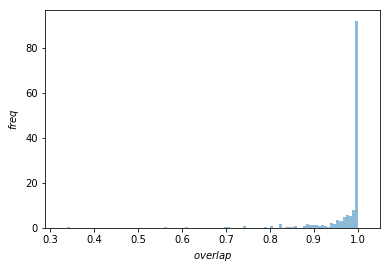

In [21]:
data = np.array(y_core) 

#plt.legend(loc='best')
plt.xlim([min(data)-0.05, max(data)+0.05])
plt.hist(data, bins='auto', alpha=0.5,density=True)
plt.xlabel('$overlap$')
plt.ylabel('$freq$')
plt.show()

In [22]:
data_reduced={x:[] for x in list(set(X))}
for item in data:
    data_reduced[item[0]]+=[item[1]]

IndexError: invalid index to scalar variable.

In [139]:
data_reduced={x:[np.mean(data_reduced[x]),np.max(data_reduced[x]),np.min(data_reduced[x]),np.std(data_reduced[x])] for x in data_reduced.keys()}

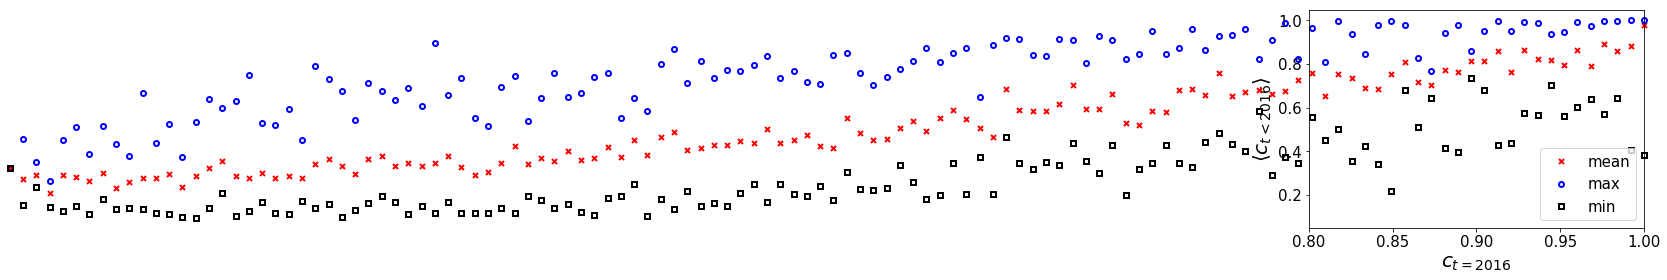

In [140]:
plt.plot(list(data_reduced.keys()),list(zip(*list(data_reduced.values())))[0],'r',marker='x',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.,label='mean')
plt.plot(list(data_reduced.keys()),list(zip(*list(data_reduced.values())))[1],'b',marker='o',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.,label='max')
plt.plot(list(data_reduced.keys()),list(zip(*list(data_reduced.values())))[2],'k',marker='s',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.,label='min')

plt.legend(loc='best')
plt.xlim([0.8, 1])

#plt.errorbar(list(data_reduced.keys()),list(zip(*list(data_reduced.values())))[0],yerr=list(zip(*list(data_reduced.values())))[1],linewidth=0.5)
plt.ylabel(r'$\langle c_{t < 2016} \rangle$',fontsize=20)
plt.xlabel(r'$c_{t=2016}$',fontsize=20)
plt.rcParams.update({'font.size': 15})
plt.savefig('core_number.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

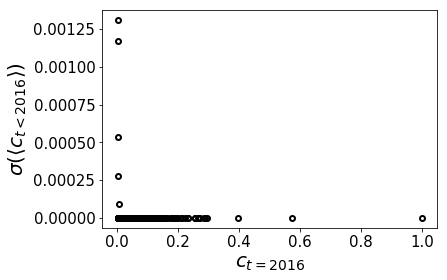

In [43]:
plt.plot(list(data_reduced.keys()),list(zip(*list(data_reduced.values())))[1],'k',marker='o',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.)

plt.ylabel(r'$\sigma(\langle c_{t < 2016} \rangle)$',fontsize=20)
plt.xlabel(r'$c_{t=2016}$',fontsize=20)
plt.rcParams.update({'font.size': 15})
plt.savefig('core_number_sigma.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

In [47]:
## analizamos las palabras del 2010 que "suben"
words_2010_up=list(core_number_by_year['2016'].keys())
## y creamos un diccionario donde se guarda el core number normalizado de estas palabras en 2011-2016
words_evolution_up={}

In [48]:
for word in log_progress(words_2016,every=100):
    for key in keys_doi[1:]:
        if word in core_number_by_year[key].keys():
            count_pair=0
            for pair in list(zip(keys_doi,keys_doi[1:])):
                if word in core_number_by_year[pair[0]].keys() and word in core_number_by_year[pair[1]].keys():
                    #if core_number_by_year[pair[0]][word]<=core_number_by_year[pair[1]][word]:
                    count_pair+=1
            if count_pair==6 and core_number_by_year['2010'][word]<core_number_by_year['2016'][word]:
                words_evolution_up[word]=[core_number_by_year[key][word] for key in keys_doi]        

In [49]:
data_up=[[words_evolution_up[word][0],np.mean(words_evolution_up[word][1:])] for word in words_evolution_up.keys()]

In [50]:
data_up

[[0.10073914476090992, 0.10258021077485598],
 [0.1824861814890762, 0.18805354385344816],
 [0.03232763461999761, 0.03987338516726808],
 [0.050784396413562014, 0.06078349592425361],
 [0.09426259058728763, 0.1363834067751953],
 [0.02914306028861225, 0.039625539536046174],
 [0.013116743325906566, 0.02044492850805737],
 [0.0068111135834784415, 0.013655363742848528],
 [0.3647518046231527, 0.43302200236205163],
 [0.08474938399110891, 0.10906366446023867],
 [0.2005109720706929, 0.24152727050095665],
 [0.20572965626371423, 0.2651327185415665],
 [0.1460042239304946, 0.1695586885826743],
 [0.003184659216723203, 0.006959484808717616],
 [0.011788165742135067, 0.01253758394119333],
 [0.02314552448951533, 0.0331585003980443],
 [0.02538044266056103, 0.03332083519944608],
 [0.010191317499897238, 0.012708933446317718],
 [0.052940303229656455, 0.06292096622926675],
 [0.06958947351103718, 0.09157936389605324],
 [0.0078308835001589, 0.013675451059691679],
 [0.07821281447952018, 0.08361906070314595],
 [0.13

In [51]:
X=list(zip(*data_up))[0]
Y=list(zip(*data_up))[1]

In [52]:
data_reduced_up={x:[] for x in list(set(X))}
for item in data_up:
    data_reduced_up[item[0]]+=[item[1]]

In [53]:
data_reduced_up={x:[np.mean(data_reduced_up[x]),np.std(data_reduced_up[x])] for x in data_reduced_up.keys()}

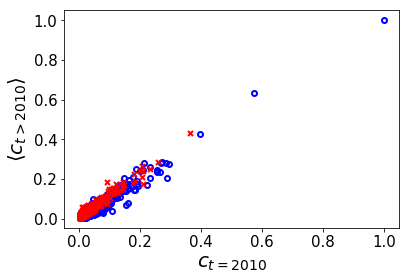

In [54]:
plt.plot(list(data_reduced.keys()),list(zip(*list(data_reduced.values())))[0],'b',marker='o',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.)
plt.plot(list(data_reduced_up.keys()),list(zip(*list(data_reduced_up.values())))[0],'r',marker='x',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.)

#plt.errorbar(list(data_reduced.keys()),list(zip(*list(data_reduced.values())))[0],yerr=list(zip(*list(data_reduced.values())))[1],linewidth=0.5)
plt.ylabel(r'$\langle c_{t > 2010} \rangle$',fontsize=20)
plt.xlabel(r'$c_{t=2010}$',fontsize=20)
plt.rcParams.update({'font.size': 15})
plt.savefig('core_number_up.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

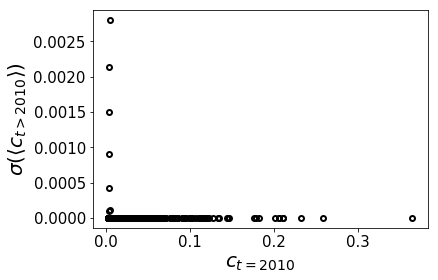

In [55]:
plt.plot(list(data_reduced_up.keys()),list(zip(*list(data_reduced_up.values())))[1],'k',marker='o',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.)

plt.ylabel(r'$\sigma(\langle c_{t > 2010} \rangle)$',fontsize=20)
plt.xlabel(r'$c_{t=2010}$',fontsize=20)
plt.rcParams.update({'font.size': 15})
plt.savefig('core_number_sigma_up.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

In [49]:
decomposition_shell_cell={}
for key in log_progress(keys_doi, every=1):
    G=graphs_cell[key]
    core_numbers=list(set(nx.core_number(G).values()))
    dict_shell={}
    for k in core_numbers:
        dict_shell[k]=nx.k_crust(G,k)
    decomposition_shell_cell[key]=dict_shell

In [50]:
pickle.dump(decomposition_shell_cell,open('decomposition_shell_cell.p','wb'))

### shell decomposition

In [51]:
decomposition_shell_cell = pickle.load(open('decomposition_shell_cell.p', 'rb')) ## solo para el 2016
text_cell = pickle.load(open( 'text_cell.p', 'rb' ) )

In [52]:
text_cell = pickle.load(open( 'text_cell.p', 'rb' ) )

In [53]:
def NTvsT(decomposition,words_text,graphs): 
    cumulated_words_core=[]
    words_dict_core={}
    
    for k in sorted(decomposition.keys()):
        words=words_text[k]
        core_words=list(decomposition[k].nodes())
        
        words=[item for sublist in words for item in sublist if item in core_words]
        cumulated_words_core+=words
        
        total_words=len(cumulated_words_core)
        total_diff=len(list(set(cumulated_words_core)))
        largest = max(nx.connected_components(decomposition[k]), key=len)
        cc=np.mean(list(nx.clustering(decomposition[k],weight='weight').values()))
        words_dict_core[k]=[total_words,total_diff,len(core_words),nx.number_connected_components(decomposition[k]),len(largest),len(largest)/float(len(decomposition[k])),cc,nx.average_shortest_path_length(decomposition[k].subgraph(largest),weight='weight')]
    
    return words_dict_core

In [55]:
for key in decomposition_shell_cell.keys():
    seq=list(decomposition_shell_cell[key].keys())
    pieces = 50
    m = float(len(seq))/pieces
    seq_of_seqs=[seq[int(m*i):int(m*(i+1))] for i in range(pieces)]
    S=[]
    for L in seq_of_seqs:
        L=[decomposition_shell_cell[key][i] for i in L]
        S+=[nx.disjoint_union_all(L)]
    decomposition_shell_cell[key]=S

In [56]:
list_by_year=list(zip(*list(decomposition_shell_cell.values())))

In [57]:
data=[]
for item in list_by_year:
    item={x:y for x,y in zip(decomposition_shell_cell.keys(),item)}
    data+=[item]

In [58]:
for i in log_progress(range(len(data)),every=1):
    data[i]=NTvsT(data[i],text_cell,graphs_cell)

KeyboardInterrupt: 

In [39]:
data_2016=[item['2016'] for item in data]

In [40]:
data_clustering=[np.mean(L) for L in list(zip(*[list(zip(*[item[key] for item in data]))[6] for key in decomposition_shell_cell.keys()]))]
data_clustering_error=[np.std(L) for L in list(zip(*[list(zip(*[item[key] for item in data]))[6] for key in decomposition_shell_cell.keys()]))]

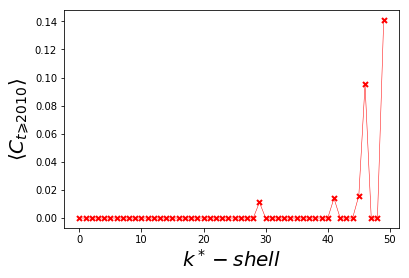

In [41]:
plt.plot(range(50),data_clustering,'r',marker='x',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)
#plt.errorbar(range(1,66),data_clustering,data_clustering_error,'k',clip_on=False,linewidth=0.5)

plt.ylabel(r'$\langle C_{t \geqslant 2010} \rangle$',fontsize=20)
plt.xlabel(r'$k^*-shell$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('cc_k*shell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

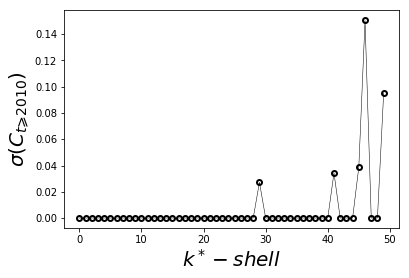

In [42]:
plt.plot(range(50),data_clustering_error,'k',marker='o',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)
#plt.errorbar(range(1,66),data_clustering,data_clustering_error,'k',clip_on=False,linewidth=0.5)

plt.ylabel(r'$\sigma(C_{t \geqslant 2010})$',fontsize=20)
plt.xlabel(r'$k^*-shell$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('sigma_cc_k*shell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

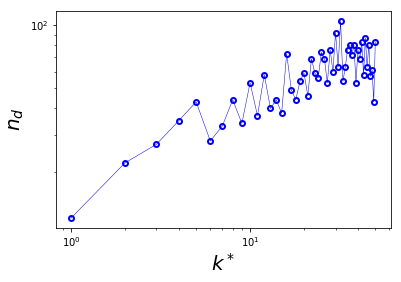

In [43]:
plt.loglog(range(1,51),list(list(zip(*data_2016))[1]),'b',marker='o',markersize=5,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$n_d$',fontsize=20)
plt.xlabel(r'$k^*$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('Nd_k*shell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

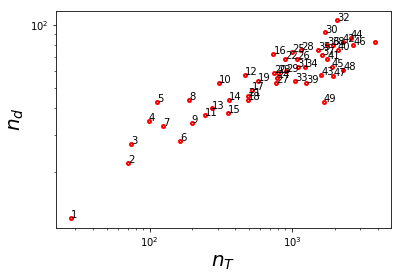

In [46]:
plt.loglog(list(list(zip(*data_2016))[0]),list(list(zip(*data_2016))[1]),'r',marker='o',markersize=3,fillstyle='none',markeredgewidth=2,clip_on=True,linewidth=0.)

for i, txt in enumerate(range(1,50)):
    plt.annotate(txt, (list(list(zip(*data_2016))[0])[:49][i],list(list(zip(*data_2016))[1])[:49][i]),fontsize=10) 
plt.ylabel(r'$n_d$',fontsize=20)
plt.xlabel(r'$n_T$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('Nd_NT.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

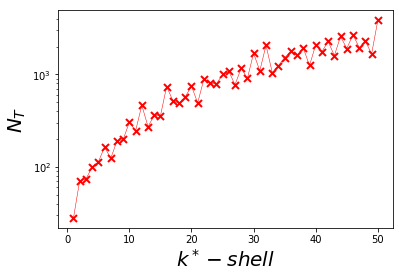

In [47]:
plt.semilogy(range(1,51),list(list(zip(*data_2016))[0]),'r',marker='x',markersize=7,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$N_T$',fontsize=20)
plt.xlabel(r'$k^*-shell$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('NT_k*shell.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()

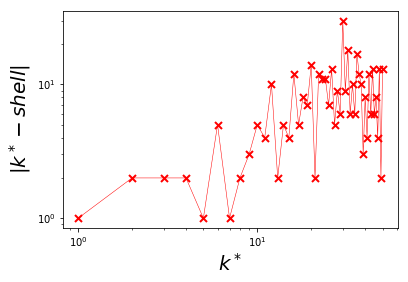

In [48]:
plt.loglog(range(1,51),list(list(zip(*data_2016))[2]),'r',marker='x',markersize=7,fillstyle='none',markeredgewidth=2,clip_on=False,linewidth=0.5)

plt.ylabel(r'$|k^*-shell|$',fontsize=20)
plt.xlabel(r'$k^*$',fontsize=20)
plt.rcParams.update({'font.size': 10})
plt.savefig('k*shell_size.pdf', format='pdf', transparent=True, bbox_inches='tight',dpi=1000)
plt.show()